### Unit 2: Lesson 4: Unit 2: Lesson 4: Project 4 Challenge: Multivariable Regression: 2013 New York Crime
#### Objectives: Clean and Prepare Data, then Create an OLS Model to Predict Property Crime
Saheed Tijani

Dec 28, 2018

##### NOTE: This solution builds on the initial data preparation assignment in Unit2_Lesson4_drill1 submitted via: 
https://github.com/datafrick/Thinkful_desk/blob/master/unit2_lesson4_drill1.ipynb

In [190]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy
from scipy import stats
from scipy.stats import boxcox
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


In [191]:
#grab the raw data

data_raw = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013_csv.csv', header=None)

#### Data cleaning

In [192]:
#remove data rows(0,1,2 and 3), and the last 3 rows. This row are only describe the data. They do not have statistical values.
#drop the rape1 col as well as it has not observation.
data_cleaning = data_raw.drop(data_raw.index[:5]).drop(data_raw.index[-3:])
#.drop('rape_1', axis=1)

#name data columns
data_cleaning.columns = ['city', 'population', 'violent_crime', 'murder_manslaughter',
       'rape_1', 'rape_2', 'robbery', 'aggravated_assault', 'property_crime', 
       'burglary', 'larceny_theft', 'mv_theft', 'arson_3']

#drop the rape1 col as it has no observation.
data_cleaning = data_cleaning.drop('rape_1', axis=1)

# Remove commas in numbers in relevant cols
data_cleaning['population'] = data_cleaning['population'].str.replace(',', '')
data_cleaning['robbery'] = data_cleaning['robbery'].str.replace(',', '')

#data is now clean and ready for feature engineering, let's name the clean data
data_cleaned = data_cleaning

#overview overview of clean data
data_cleaned.head()

,city,population,violent_crime,murder_manslaughter,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3
5,Adams Village,1861,0,0,0,0,0,12,2,10,0,0
6,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0
7,Akron Village,2846,3,0,0,0,3,16,1,15,0,0
8,Albany,97956,791,8,30,227,526,"4,090",705,"3,243",142,NaN
9,Albion Village,6388,23,0,3,4,16,223,53,165,5,NaN


### Creating Features

In [193]:
#create the population-square feature
data_cleaned['population_square'] =  (data_cleaned['population']).astype(int)**2

#create a function to categrize continous data
def cont_2_cat(col):
    for element in col:
        if int(element) > 1:
            return 1
        else:
            return 0
#apply our cont_2_cat function to catgorize data_cleaned.murder_manslaughter and create feature with the result       
data_cleaned['murder_manslaughter_categorical'] = data_cleaned.murder_manslaughter.apply(cont_2_cat)

#use the npwhere method to categorize roberry and create a feature with it
#I could'nt figure out why - feature_data['robbery_categorical'] = np.where(int(data_cleaned['robbery']) > 1 ,1,0) did not work
data_cleaned['robbery_categorical'] = np.where((data_cleaned['robbery']).astype(int) > 1 ,1,0)

#final data overview
data_cleaned

,city,population,violent_crime,murder_manslaughter,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3,population_square,murder_manslaughter_categorical,robbery_categorical
5,Adams Village,1861,0,0,0,0,0,12,2,10,0,0,3463321,0,0
6,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0,6640929,0,0
7,Akron Village,2846,3,0,0,0,3,16,1,15,0,0,8099716,0,0
8,Albany,97956,791,8,30,227,526,"4,090",705,"3,243",142,NaN,1005443344,1,1
9,Albion Village,6388,23,0,3,4,16,223,53,165,5,NaN,40806544,0,1
10,Alfred Village,4089,5,0,0,3,2,46,10,36,0,NaN,16719921,0,1
11,Allegany Village,1781,3,0,0,0,3,10,0,10,0,0,3171961,0,0
12,Amherst Town,118296,107,1,7,31,68,"2,118",204,"1,882",32,3,1109041728,0,1
13,Amityville Village,9519,9,0,2,4,3,210,16,188,6,1,90611361,0,1
14,Amsterdam,18182,30,0,0,12,18,405,99,291,15,0,330585124,0,1


#### The Modellimg Part starts from here

##### Criteria for selecting independent variables;
1. Independent variable must not be closely correlated
2. Indenpent variables should share a linear relationship (as close as possible) with the outcome variable
3. Each variable on it's own must be close to ideal normal distribution as possible

We will now examine our indepepent variables and select those to be included in our model based on the above criteria

##### Further data cleaning

In [194]:
#first let's slice out only the numerical columns of the data to enable analysis
data_cleaned_num = data_cleaned.loc[:, 'population': ]

#next remove comma and convert all the values to int
col = data_cleaned_num.columns.tolist()
for element in col:
    data_cleaned_num[element] = data_cleaned_num[element].astype(str).str.replace(',','').replace('nan', 0).astype(int)

##### Feature Engineering

Generate correlation matrix and plot heat map:


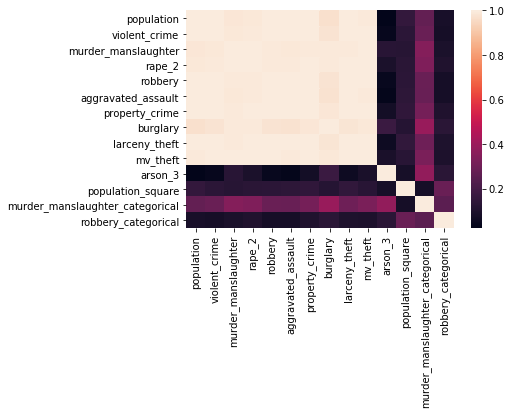

In [195]:
#Checking for correllation through correlation matrix and heat map diagram
print('Generate correlation matrix and plot heat map:')
data_cleaned_num.corr()
sns.heatmap(data_cleaned_num.corr())

##### Addrissing variable correllation:
As can be seen above, we have strong **correllation** between: **population**, **violent_crime**, **Murder_manslaughter**, **rape_2**, **robbery**, **aggravated_assault**, **property_crime**, **burglary**, **larceny_theft** and **mv_theft**. Since a feature (population_square) has initially been created from population, population as a variable will hence forthbe dropped. The remaining 8 correlating features will then be scaled and combined as a single feature.

In [196]:
#drop the populaton col
data_cleaned_num.drop('population', axis=1, inplace=True)

scaler = MinMaxScaler() #imported from sklearn.preprocessing
data_cleaned_num = pd.DataFrame(scaler.fit_transform(data_cleaned_num), columns=data_cleaned_num.columns)

#let's now create a single feature using the mean of all the 8 correllated variables 
# create the column names for the correllated variables
cor_var_col = col[1:6] + col[7:10]

#create the correllatd variables dataframe
cor_var = pd.DataFrame()
cor_var[cor_var_col] = data_cleaned_num[cor_var_col]

data_cleaned_num['cor_var_feature'] = cor_var[cor_var_col].mean(axis=1)

#will now drop all the correllated variables from our data since they have all be represented by a single feature(cor_var)
data_cleaned_num.drop(cor_var_col, axis=1, inplace=True)


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##### Let's do a pair plot of our features and outcome variable to see the what they look like.

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


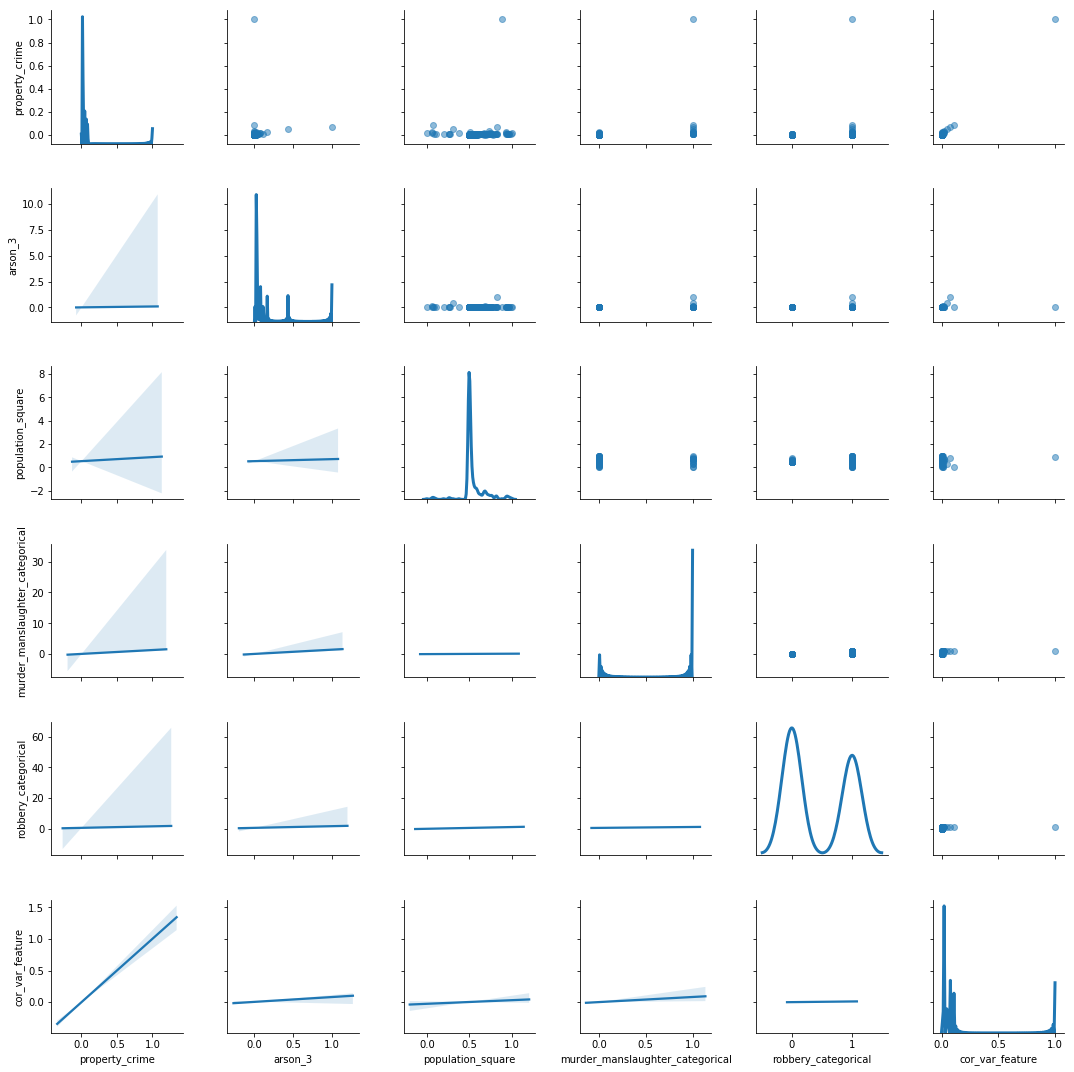

In [205]:
g = sns.PairGrid(data_cleaned_num.dropna(how = 'any', axis = 0), diag_sharey=False)

#Scatterplot.
g.map_upper(plt.scatter, alpha=.5)

#Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

#Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

##### Now we have five independent variables made up of purely features(manipulation of the independent variables). We will check them again for correllation.

Generate correlation matrix and plot heat map:


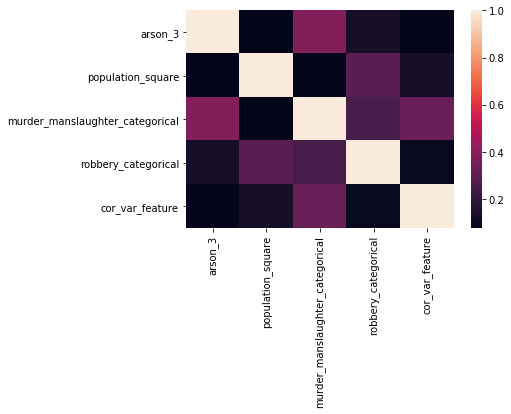

In [197]:
#let's re-draw our heatmap

#Checking for correllation through correlation matrix and heat map diagram
print('Generate correlation matrix and plot heat map:')
data_cleaned_num.drop('property_crime', axis=1).corr()
sns.heatmap(data_cleaned_num.drop('property_crime', axis=1).corr())

##### As we can see from the heatmap, these features are largely independent. We are now ready to run our OLS model

In [198]:
#run model using statsmodels.formula.api imported as smf 
lm_1 = smf.ols(formula = "property_crime ~ arson_3 + population_square + murder_manslaughter_categorical + 
               robbery_categorical + cor_var_feature", data = data_cleaned_num).fit()
               
#generate model's summary
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.185e+04
Date:                Sat, 29 Dec 2018   Prob (F-statistic):               0.00
Time:                        01:16:40   Log-Likelihood:                 1733.4
No. Observations:                 348   AIC:                            -3455.
Df Residuals:                     342   BIC:                            -3432.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0022      0.000     -5.434      0.000      -0.003      -0.001
arson_3                            -0.0057      0.002     -3.478      0.001      -0.009      -0.002
population_square                   0.0048      0.001      6.371      0.000       0.003       0.006
murder_manslaughter_categorical    -0.0024      0.000     -4.965      0.000      -0.003      -0.001
robbery_categorical                 0.0011      0.000      5.664      0.000       0.001       0.001
cor_var_feature                     0.9979      0.002    563.261      0.000       0.994       1.001
==============================================================================
Omnibus:                      173.018   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15004.554
Skew:                          -1.104   Prob(JB):                         0.00
Kurtosis:                      35.092   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Plot the residual error to see how evenly distributed the errors are

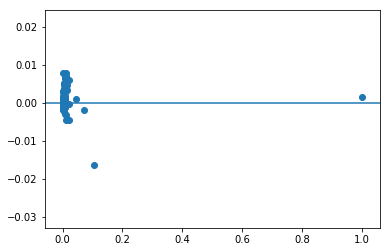

In [199]:
# Residual Error Plot
resid_1 = lm_1.resid
plt.axhline(y=0)
plt.scatter(lm_1.predict(), resid_1);

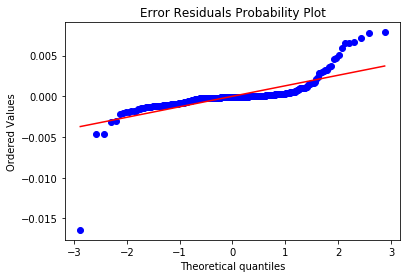

In [200]:
# Probability Plot to view normality (blue data should fit to red line of expected error)
stats.probplot(lm_1.resid, plot= plt)
plt.title("Error Residuals Probability Plot");

##### Rerun the model using the sklearn linear model rather than the stats model as per above

In [203]:
# Instantiate the model.
lin_regr = linear_model.LinearRegression()

# Fit model to data.
y_residual = data_cleaned_num['property_crime']
x_residual = data_cleaned_num[['arson_3', 'population_square', 'murder_manslaughter_categorical', 'robbery_categorical', 'cor_var_feature']]

lin_regr.fit(x_residual, y_residual)

# Extract predicted and actual values.
predicted = lin_regr.predict(x_residual).ravel()
actual = data_cleaned_num['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

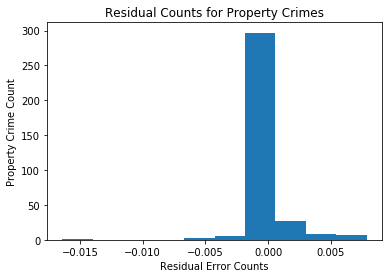

In [204]:

# Residual Error Plot
plt.hist(residual)
plt.title('Residual Counts for Property Crimes')
plt.xlabel('Residual Error Counts')
plt.ylabel('Property Crime Count')
plt.show()